In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X = mnist['data']
X.shape

(70000, 784)

In [5]:
y = mnist['target']

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
example = X[89]
reshaped_example = example.reshape(28,28)

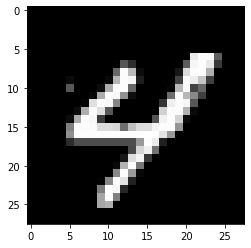

In [7]:
plt.imshow(reshaped_example, cmap='gray', interpolation='nearest')

In [8]:
y[89] # they are strings

'4'

In [9]:
y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Lets train binary classifiers for a digit and see how they perform

In [11]:
y_train_5 = (y_train == 5) # True for all 5, else false
y_test_5 = (y_test == 5)

In [12]:
# Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([example])

array([False])

Evaluating performance

In [14]:
# cross_val_score() will evaluate accuracy of the model over cv amounts of different splits of data
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This isnt very good as there are 5s roughly only 10% of the time, therefore it should be classifying not 5 90% of the time, we can test this

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # just a long list of 0s (False)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Maybe accuracy isnt the way to go on this type of classifier

In [17]:
# Confusion Matrix
# cross_val_predict returns the predictions made on each test item, not whether it is right or not
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# Rows in confusion matrix represent an actual class, columns represent a predicted class
# 687 were wrongly classified as 5s and 1891were missed
# first row is non-5s, second is 5s

We can look at the metric for precision, accuracy of positive predictions 
$$ \frac{TP}{TP+FP} $$
And then for recall, ratio of positive instances correctly detected by the classifier
$$ \frac{TP}{TP+FN} $$

In [19]:
from sklearn.metrics import precision_score, recall_score
recall_score(y_train_5, y_train_pred) # it detects on 65% of the fives

0.6511713705958311

In [20]:
precision_score(y_train_5, y_train_pred) # if it claims a 5, it is right 83%

0.8370879772350012

$$f_1 = 2*\frac{\text{precision}*\text{recall}}{\text{precision}+\text{recall}}$$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

There exists a precision recall tradeoff

In [22]:
# use the decision function to see values computed by the classifier
some_digit = X_test[10]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-3714.3241421])

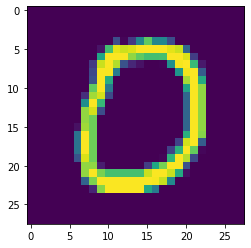

In [23]:
plt.imshow(np.reshape(some_digit, (28,28))) # makes sense that it has a negative threshold value then

Raising threshold reduces recall, lowering it reduces precision

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

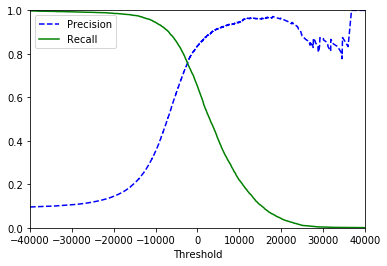

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc=0)
    plt.ylim([0,1])
    plt.xlim([-40000, 40000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

We could choose the value that has the best precision recall tradeoff for this data set, if we want a higher one or the other we could adjust accordingly

Text(0, 0.5, 'Precision')

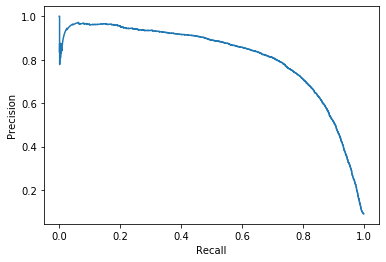

In [27]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [28]:
y_train_pred_90 = (y_scores > 5000)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9160050146259925

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.40435344032466336

ROC Curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

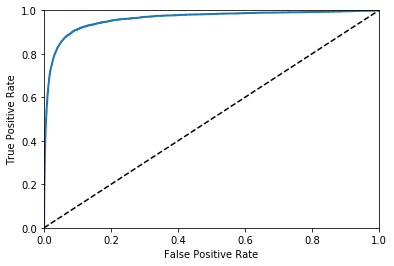

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

One was to compare classifiers is to measure the area under the ROC curve

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Use the PR curve when the positive class is rare and we care more about the false positives than the false negatives

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
y_scores_forest = y_probas_forest[:, 1] # scores = probabilties of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

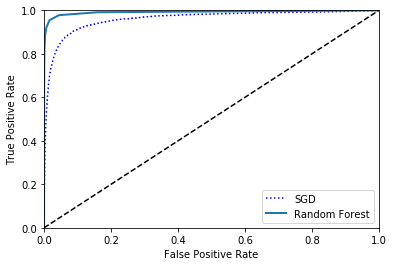

In [36]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc=4)

Random Forest popped off

In [37]:
roc_auc_score(y_train_5, y_scores_forest) # boom!

0.9920527492698306

In [38]:
precision_score(y_train_5, (y_scores_forest>.5))

0.986046511627907

In [39]:
recall_score(y_train_5, (y_scores_forest>.5))

0.8212506917542889

Lets create an multiclass classifier

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0], dtype=uint8)

In [41]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  1736.84699422, -37025.92060593,  -5806.94570663,
         -9490.39645261, -17811.48663261,  -2547.22980615,
        -20251.3340711 , -23972.34687729,  -1434.39134104,
        -15519.29769876]])

In [42]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Can create 1v1 classifiers like so

In [43]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=uint8)

In [44]:
len(ovo_clf.estimators_)

45

In [45]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0], dtype=uint8)

In [46]:
forest_clf.predict_proba([some_digit])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

We can increase accuracy easily by doing some preprocessing on the data

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy') # that took forever

/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [50]:
X_train_scaled[3]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00441808, -0.00575482, -0.00408252,
       -0.00408252,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00408252, -0.00470969, -0.00879935,
       -0.01159056, -0.01475898, -0.01928485, -0.0246718 , -0.02907103,
       -0.03059266, -0.03116401, -0.03196287, -0.03020254, -0.03131022,
       -0.0283834 , -0.02311919, -0.01916663, -0.0167723 , -0.01099636,
       -0.00832486, -0.00438069,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00408252, -0.00539535,
       -0.00852241, -0.01198504, -0.01765348, -0.0277109 , -0.03702009,
       -0.05215128, -0.0670362 , -0.08301705, -0.0993793 , -0.11

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

/home/jstox/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


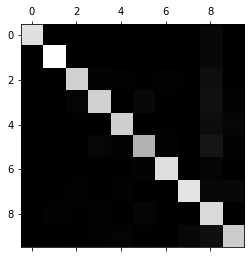

In [52]:
plt.matshow(conf_mx, cmap='gray')

In [53]:
conf_mx

array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [56]:
np.fill_diagonal(norm_conf_mx, 0)

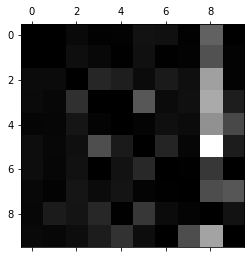

In [57]:
plt.matshow(norm_conf_mx, cmap='gray')

Multi-Label Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
knn_clf.predict([some_digit])

array([[0, 0]], dtype=uint8)

Multi-output multi-class calssification

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

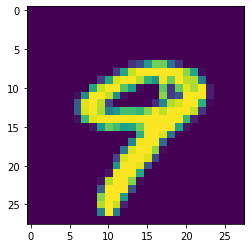

In [61]:
plt.imshow(np.reshape(X_test[9], (28,28)))

To improve accuracy lets make a function that shifts numbers over

In [65]:
def shift(num, direction):
    num_reshape = np.reshape(num, (28,28))
    if direction == 0: # this one works
        temp = num_reshape[:1, :]
        num_reshape[:-1, :] = num_reshape[1:, :]
        num_reshape[-1:,:] = temp
    elif direction == 1:
        temp = num_reshape[:, :1]
        num_reshape[:, :-1] = num_reshape[:, 1:]
        num_reshape[:, -1:] = temp
    elif direction == 2:
        temp = num_reshape[-1:, :]
        num_reshape[1:, :] = num_reshape[:-1, :]
        num_reshape[:1, :] = temp
    elif direction == 3:
        temp = num_reshape[:, -1:]
        num_reshape[:, 1:] = num_reshape[:, :-1]
        num_reshape[:, :1] = temp
    else:
        print('Choose between 0-3 for direction')
    return np.reshape(num_reshape, (784,))

In [66]:
n = shift(X_test[9], 0)

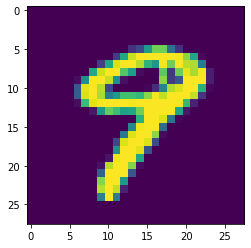

In [67]:
plt.imshow(np.reshape(n, (28,28)))

In [69]:
type(X)

numpy.ndarray

In [107]:
import time
t = time.time()
X_train, X_test, y_train, y_test = X[:1000], X[1000:], y[:1000], y[1000:]
for i in range(len(X_train)):
    for j in range(4):
        n = shift(X_train[i], j)
        X_train = np.vstack([X_train, np.reshape(n, (1, 784))]) # add to X_train
        y_train = np.append(y_train, np.array([y_train[i]])) # add label to y_train
print(time.time() - t)

21.151248693466187


21.151248693466187 seconds to complete, so should take around 21 mins to complete all, however this didnt work last time, so I will plot the times and see if there is exponential time for some reason

In [108]:
times = []
for size in range(2, 100, 2):
    t = time.time()
    x_t, y_t = X[:size], y[:size]
    for i in range(len(x_t)):
        for j in range(4):
            n = shift(X_train[i], j)
            x_t = np.vstack([x_t, np.reshape(n, (1, 784))]) # add to X_train
            y_t = np.append(y_t, np.array([y_train[i]])) # add label to y_train
    times.append(time.time() - t)

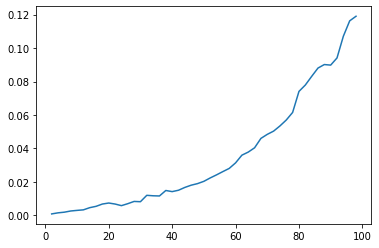

In [109]:
plt.plot([x for x in range(2, 100, 2)], times)

This is why, exponential time, probably has something to do with vstack

In [110]:
times = []
for size in range(2, 100, 2):
    t = time.time()
    x_t, y_t = X[:size], y[:size]
    for i in range(len(x_t)):
        for j in range(4):
            n = shift(X_train[i], j)
            #x_t = np.vstack([x_t, np.reshape(n, (1, 784))]) # add to X_train
            y_t = np.append(y_t, np.array([y_train[i]])) # add label to y_train
    times.append(time.time() - t)

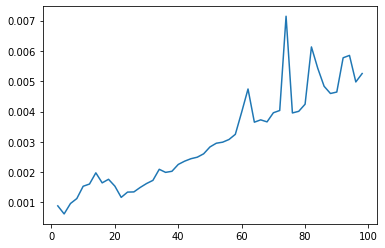

In [111]:
plt.plot([x for x in range(2, 100, 2)], times)

Just about linear, I wonder what the jumps are for?

In [112]:
x_t[1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   